In [1]:
import torch
import matplotlib.pyplot as plt
from conex import Neocortex, prioritize_behaviors, SimpleDendriteStructure, SimpleDendriteComputation, SpikeTrace, \
    NeuronAxon, SynapseInit, WeightInitializer, SimpleDendriticInput, SimpleSTDP, Fire, WeightClip, LIF, \
    WeightNormalization, KWTA, ActivityBaseHomeostasis, VoltageBaseHomeostasis
from pymonntorch import NeuronGroup, NeuronDimension, SynapseGroup, EventRecorder, Recorder

from models.activity import ActivityRecorder
from models.dendrites import LateralDendriticInput2D, LateralInhibitionDendriticInput
from models.encoders import FeedDataset, CustomPoisson, Poisson
from models.learnings import PairedSTDPLocalVar, PairedRSTDPLocalVar
from models.trace import ClearSpikeTrace
from simulate import Simulation
from utils.dataset import load_data, add_overlap
from utils.formatter import pretty_format_dict
from utils.plots import add_colorized_raset_plot


# Different number of patterns for Lateral inhibition

In [2]:
def default_simulation(dataset, num_feed, instance_duration, sleep, normalization=True, **kwargs):
    input_layer_parameters = {
        "input_layer_tau": 10,
        "input_layer_v_rest": -65.0,
        "input_layer_v_reset": -70.0,
        "input_layer_threshold": -55,
        "input_layer_R": 1.7,
        'input_layer_tau_s':4,
    }
    output_layer_parameters = {
        "output_layer_tau": 10,
        "output_layer_v_rest": -65.0,
        "output_layer_v_reset": -70.0,
        "output_layer_threshold": -55,
        "output_layer_R": 1.7,
        'output_layer_tau_s':3
    }
    syn_inp_out_prarameters = {
        'w_max':1,
        'w_min':0,
        'a_plus':0.1,
        'a_minus':0.03,
        'positive_bound':'soft_bound',
        'negative_bound':'soft_bound',
        'weight_mode': 'normal(0,0.5)',
        'current_coef': 100,
    }
    dataset_parameters = {
        'num_data': dataset.shape[0],
    }
    ALL_PARAMETERS = {
        **input_layer_parameters,
        **output_layer_parameters,
        **syn_inp_out_prarameters,
        **dataset_parameters,
        **kwargs
    }
    sim = Simulation(net=Neocortex(dt=1))
    input_layer = sim.add_neuron_group(
        tag="input_layer",
        # size=NeuronDimension(depth=1, height=1, width=18),
        size=dataset.shape[1],
        behavior=prioritize_behaviors(
            [
                SimpleDendriteStructure(),
                SimpleDendriteComputation(),
                LIF(
                    tau=ALL_PARAMETERS["input_layer_tau"],
                    v_rest=ALL_PARAMETERS["input_layer_v_rest"],
                    v_reset=ALL_PARAMETERS["input_layer_v_reset"],
                    threshold=ALL_PARAMETERS["input_layer_threshold"],
                    R=ALL_PARAMETERS["input_layer_R"],
                ),
                SpikeTrace(tau_s=ALL_PARAMETERS['input_layer_tau_s']),
                NeuronAxon(),
            ]
        ),
    )
    input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
    input_layer.add_behavior(key=350, behavior=ActivityRecorder())
    input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
    input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

    output_layer = sim.add_neuron_group(
        tag='output_layer',
        size=dataset.shape[0],
        behavior=prioritize_behaviors(
            [
                SimpleDendriteStructure(),
                SimpleDendriteComputation(),
                LIF(
                    tau=ALL_PARAMETERS["output_layer_tau"],
                    v_rest=ALL_PARAMETERS["output_layer_v_rest"],
                    v_reset=ALL_PARAMETERS["output_layer_v_reset"],
                    threshold=ALL_PARAMETERS["output_layer_threshold"],
                    R=ALL_PARAMETERS["output_layer_R"],
                ),
                Fire(),
                SpikeTrace(tau_s=ALL_PARAMETERS['output_layer_tau_s']),
                NeuronAxon(),
            ]
        ),
    )
    output_layer.add_behavior(key=350, behavior=ActivityRecorder())
    output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
    output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

    syn_inp_out = sim.add_synapse_group(
        src=input_layer,
        dst=output_layer,
        tag="Proximal",
        behavior=prioritize_behaviors(
            [
                SynapseInit(),
                WeightInitializer(mode=ALL_PARAMETERS['weight_mode']),
                SimpleDendriticInput(current_coef=ALL_PARAMETERS['current_coef']),
            ]
        ),
    )
    if normalization:
        syn_inp_out.add_behavior(key=420, behavior=WeightNormalization(), initialize=False)
    syn_inp_out.add_behavior(key=400,
                             behavior=SimpleSTDP(
                                            w_max=ALL_PARAMETERS['w_max'],
                                            w_min=ALL_PARAMETERS['w_min'],
                                            a_plus=ALL_PARAMETERS['a_plus'],
                                            a_minus=ALL_PARAMETERS['a_minus'],
                                            positive_bound=ALL_PARAMETERS['positive_bound'],
                                            negative_bound=ALL_PARAMETERS['negative_bound']),
                             initialize=False
                             )
    syn_inp_out.add_behavior(key=401,
                            behavior=ClearSpikeTrace())
    syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))
    return sim

In [3]:
NUM_DATA = 2
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA,:]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [17]:
sim1 = default_simulation(dataset=dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          normalization=False,
                          w_max=1,
                          a_plus=0.5,
                          a_minus=0.2,
                          current_coef=5,
                          weight_mode='normal(0.1,0.05)')
input_layer = sim1.net.NeuronGroups[0]
output_layer = sim1.net.NeuronGroups[1]
syn_inp_out = sim1.net.SynapseGroups[0]
# syn_out_out = sim1.add_synapse_group(
#     src=output_layer,
#     dst=output_layer,
#     tag="Proximal",
#     behavior=prioritize_behaviors(
#         [
#             SynapseInit(),
#             WeightInitializer(mode='ones'),
#         ]
#     ),
# )
# syn_out_out.add_behavior(key=401,
#                          behavior=LateralInhibitionDendriticInput(current_coef=0.3,
#                                                               inhibitory=True),
#                                                               initialize=False)
# syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))
sim1.initialize()
sim1.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(502)|2 groups, Synapses: tensor(1000)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[ True, False,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [ True,  True, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  

In [89]:
NUM_DATA = 3
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA,:]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [102]:
sim2 = default_simulation(dataset=dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          normalization=False,
                          w_max=1,
                          a_plus=0.2,
                          a_minus=0.2,
                          current_coef=4,
                          weight_mode='normal(0.15,0.05)')
input_layer = sim2.net.NeuronGroups[0]
output_layer = sim2.net.NeuronGroups[1]
syn_inp_out = sim2.net.SynapseGroups[0]
sim2.initialize()
sim2.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(503)|2 groups, Synapses: tensor(1500)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True, False,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


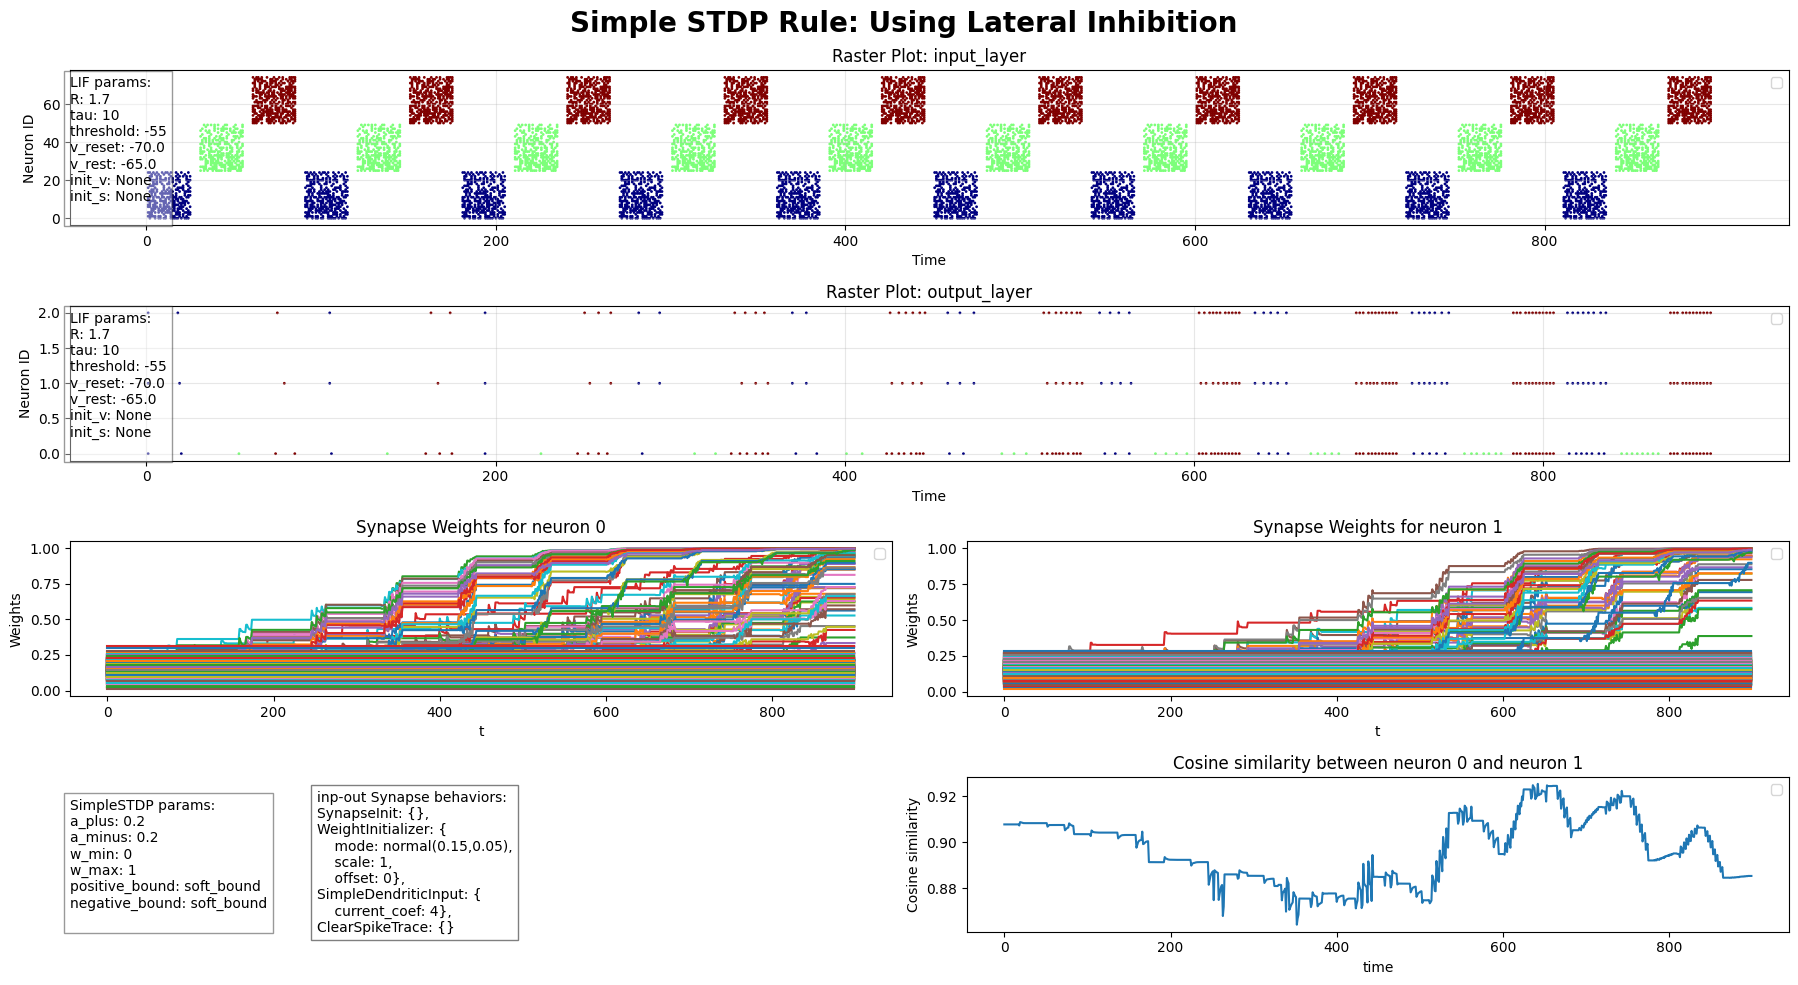

In [103]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


# params_info = dict()
# for key, behavior in syn_out_out.behavior.items():
#     if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
#         params_info[behavior.__class__.__name__]= behavior.init_kwargs
#     if behavior.__class__.__name__ == "WeightInitializer":
#         params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
# params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
# ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
#                 fontsize=10)
#
#
ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using Lateral Inhibition", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("../report/plots/without-normalization/part1-simple-stdp.pdf")
plt.show()

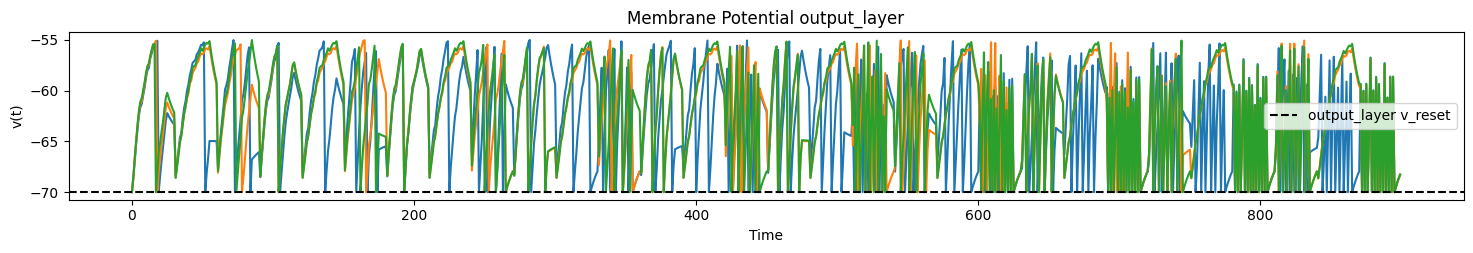

In [104]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
output_layer.add_membrane_potential_plot(ax=ax1, recorder_behavior_class=Recorder, neuron_model_class=LIF)
plt.show()

In [105]:
ex

NameError: name 'ex' is not defined

In [ ]:
sim1 = Simulation(net=Neocortex(dt=1))
input_layer = sim1.add_neuron_group(
    tag="input_layer_2_patterns",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim1.add_neuron_group(
    tag='output_layer_2_patterns',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))
syn_inp_out = sim1.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=600.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.1,
                                        a_minus=0.03,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim1.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=600.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim1.initialize()
sim1.simulate_iterations(iterations=NUM_ITERATION)

### On 3 data

In [ ]:
NUM_DATA = 3
FEED_NUM = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * FEED_NUM * NUM_DATA
dataset = load_data(directory='dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA,:]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [ ]:
sim2 = Simulation(net=Neocortex(dt=1))
input_layer = sim2.add_neuron_group(
    tag="input_layer_3_patterns",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim2.add_neuron_group(
    tag='output_layer_3_patterns',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=NUM_DATA,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))
syn_inp_out = sim2.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.08,
                                        a_minus=0.025,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim2.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=350.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim2.initialize()
sim2.simulate_iterations(iterations=NUM_ITERATION)

### 5 patterns:

In [ ]:
NUM_DATA = 5
FEED_NUM = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * FEED_NUM * NUM_DATA
dataset = load_data(directory='dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA,:]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [ ]:
sim3 = Simulation(net=Neocortex(dt=1))
input_layer = sim3.add_neuron_group(
    tag="input_layer_5_patterns",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim3.add_neuron_group(
    tag='output_layer_5_patterns',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=NUM_DATA,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim3.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.08,
                                        a_minus=0.025,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim3.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=350.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim3.initialize()
sim3.simulate_iterations(iterations=NUM_ITERATION)

In [ ]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using Lateral Inhibition", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

In [ ]:
NUM_DATA = 5
FEED_NUM = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * FEED_NUM * NUM_DATA
dataset = load_data(directory='dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA,:]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [ ]:
fig = plt.figure(figsize=(18, 18))

simulations = [sim1, sim2, sim3]
for i, sim in enumerate(simulations):
    output_layer_size = sim.net.NeuronGroups[1].size
    ax1 = fig.add_subplot(10, 1, i*2+1)  # 3 rows, 1 column, first plot
    ax1.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax1, sim.net.NeuronGroups[0], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=1)

    ax2 = fig.add_subplot(10, 1, i*2+2)  # 3 rows, 1 column, first plot
    ax2.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax2, sim.net.NeuronGroups[1], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=5)



# ax1 = fig.add_subplot(10, 1, 1)  # 3 rows, 1 column, first plot
# ax1.grid(True, alpha=0.3)
# add_colorized_raset_plot(ax1, sim1.net.NeuronGroups[0], start_iteration=sim1.net.iteration - 2*(INSTANCE_DURATION+SLEEP), end_iteration=sim1.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=1)
#
# ax2 = fig.add_subplot(10, 1, 2)  # 3 rows, 1 column, first plot
# ax2.grid(True, alpha=0.3)
# add_colorized_raset_plot(ax2, sim1.net.NeuronGroups[1], start_iteration=(sim1.net.iteration - 2*(INSTANCE_DURATION+SLEEP)), end_iteration=sim1.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=5)
#
#
# ax3 = fig.add_subplot(10, 1, 3)  # 3 rows, 1 column, first plot
# ax3.grid(True, alpha=0.3)
# add_colorized_raset_plot(ax3, sim2.net.NeuronGroups[0], start_iteration=(sim2.net.iteration - 3*(INSTANCE_DURATION+SLEEP)), end_iteration=sim2.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=1)
#
# ax4 = fig.add_subplot(10, 1, 4)  # 3 rows, 1 column, first plot
# ax4.grid(True, alpha=0.3)
# add_colorized_raset_plot(ax4, sim2.net.NeuronGroups[1], start_iteration=(sim2.net.iteration - 3*(INSTANCE_DURATION+SLEEP)), end_iteration=sim2.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=5)
#
#
# ax5 = fig.add_subplot(10, 1, 3)  # 3 rows, 1 column, first plot
# ax5.grid(True, alpha=0.3)
# add_colorized_raset_plot(ax5, sim3.net.NeuronGroups[0], start_iteration=(sim3.net.iteration - 3*(INSTANCE_DURATION+SLEEP)), end_iteration=sim3.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=1)
#
# ax4 = fig.add_subplot(10, 1, 4)  # 3 rows, 1 column, first plot
# ax4.grid(True, alpha=0.3)
# add_colorized_raset_plot(ax4, sim2.net.NeuronGroups[1], start_iteration=(sim2.net.iteration - 3*(INSTANCE_DURATION+SLEEP)), end_iteration=sim2.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=5)
#
fig.suptitle("Simple STDP Rule: Using Lateral Inhibition", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()